## Adjusting and combining QUINT output

1. Combine info from all csv files per each animal: demo with two single dataframes

In [ ]:
import pandas as pd

df = pd.read_csv('/Users/annateruel/Desktop/QUINT/prova2/AD21002-2_RefAtlasRegions.csv', sep=";")
df2 = pd.read_csv('/Users/annateruel/Desktop/QUINT/prova2/AD21002-3_RefAtlasRegions.csv', sep=";")


df3 = df.loc[:,('Region name','Object count')]
df4 = df2.loc[:,('Region name','Object count')]

df5 = df3.add(df4)
df5.transpose()

2. We collect all files of interest from each animal, for abeta intra, abeta extra, and tau, in one single folder. If all files are in the same folder it will be easier to combine. 

In [ ]:
import pandas as pd
import os
main = '/Volumes/ANNA_HD/ANALYSIS/QUINT/data'
output = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output'
animal_data = {}

for animal_folder in os.listdir(main):
    animal_path = os.path.join(main, animal_folder)
    
    if os.path.isdir(animal_path):
        for marker_folder in ["abeta_extra","abeta_intra","tau"]:
            marker_path = os.path.join(animal_path, "nutil", marker_folder, "Reports", animal_folder + "_RefAtlasRegions")
            csv_files = [f for f in os.listdir(marker_path) if f.endswith("RefAtlasRegions.csv")]
                    
            for csv_file in csv_files:
                csv_path = os.path.join(marker_path, csv_file)
                if csv_file.endswith(".csv"):
                    df = pd.read_csv(csv_path, sep=";")
                            
                    # Perform operations on the DataFrame
                    result_df = df.loc[:, ('Region name', 'Object count')]
                            
                    # Get information about the animal and marker
                    animal_marker_info = f"{animal_folder}-{marker_folder}"
                            
                    if marker_folder == "abeta_extra": 
                        output = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_extra'  
                        # Create the output file path
                        output_file_path = os.path.join(output, f"{animal_marker_info}.csv")    
                        result_df.to_csv(output_file_path, encoding = 'utf8')
                    elif marker_folder == "abeta_intra": 
                        output = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra'  
                        # Create the output file path
                        output_file_path = os.path.join(output, f"{animal_marker_info}.csv")    
                        result_df.to_csv(output_file_path,  encoding = 'utf8')
                    elif  marker_folder == "tau": 
                        output = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/tau'  
                        # Create the output file path
                        output_file_path = os.path.join(output, f"{animal_marker_info}.csv")    
                        result_df.to_csv(output_file_path,  encoding = 'utf8')

3. Combine csv from each animal, for abeta intra, abeta extra and protein tau, using pandas add function

In [ ]:
import pandas as pd
import os

input_directory = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/'
output_directory = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/'

group_data = {}

for file_name in os.listdir(input_directory):
    file_path = os.path.join(input_directory, file_name)
    if file_name.startswith("._"):
        file_path = os.path.join(input_directory, file_name)
        os.remove(file_path)
    else:
        prefix = file_name.split("-")[0]
        df = pd.read_csv(file_path)
        
        if prefix not in group_data:
            group_data[prefix] = df.set_index('Region name')
        else:
            group_data[prefix] = group_data[prefix].add(df.set_index('Region name'), fill_value=0)

for prefix, df in group_data.items():
    output_file_path = os.path.join(output_directory, f"{prefix}_combined.csv")
    df.to_csv(output_file_path)


4. Combine information of all brain regions together. Because QUINT is showing the output of each brain region and cortical layer, the dataframe is too big and not representative. So we group brain regions by a common root. For example, all subregions of entorhinal cortex together. To do so, we load all combined.csv files we have generated and transform them again. 

In [ ]:
input_directory = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/'
output_directory = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/'

for file_name in os.listdir(input_directory):
    file_path = os.path.join(input_directory, file_name)
    if file_name.startswith("._"):
        file_path = os.path.join(input_directory, file_name)
        os.remove(file_path)
    elif file_name.endswith("_combined.csv"):
        df = pd.read_csv(file_path)
        df['Common label'] = df['Region name'].str.split(',').str[0].str.strip()
        grouped_df = df.groupby('Common label', as_index=False)['Object count'].sum()
        output_file_path = os.path.join(output_directory, file_name)
        grouped_df.to_csv(output_file_path, index=False)


5. Get the transpose of each dataframe and then merge all dataframes by row. Thus each row belongs to one animal.  

In [ ]:
import os
c_path = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/tau/'
c_output = '/Volumes/ANNA_HD/ANALYSIS/QUINT/output/tau/'

transposed_dataframes = {}

for file_name in os.listdir(c_path):
    if file_name.startswith("._"):
        file_path = os.path.join(c_path, file_name)
        os.remove(file_path)
    elif file_name.endswith("_combined.csv"):
        file_path = os.path.join(c_path, file_name)
        df = pd.read_csv(file_path)
        t_df = df.set_index("Common label").T

        animal_identifier = file_name.split("_")[0]
        transposed_dataframes[animal_identifier] = t_df

combined_df = pd.concat(transposed_dataframes.values(), keys=transposed_dataframes.keys())
# Save the combined dataframe
output_file_path = os.path.join(c_output, "results_tau.csv")
combined_df.to_csv(output_file_path)
        

## MANOVA and PCA on whole brain data

A "Singular matrix" error in the context of MANOVA usually indicates that the matrix being used for the analysis is not of full rank, meaning it's not invertible or has linearly dependent columns. This can occur for several reasons. So perhaps, it is not possible to run MANOVA with this raw data. Consider removing some variables or using dimensionality reduction techniques, such as PCA and t-SNE.

7. PCA: PCA is a linear dimensionality reduction technique that transforms the original variables into a new set of orthogonal variables called principal components. These components capture the maximum variance in the data. By selecting a subset of these principal components, you can effectively reduce the dimensionality of the data.
8. Distributed Stochastic Neighbor Embedding (t-SNE): t-SNE is a nonlinear dimensionality reduction technique that aims to preserve pairwise distances between data points. It's often used for visualization and clustering.

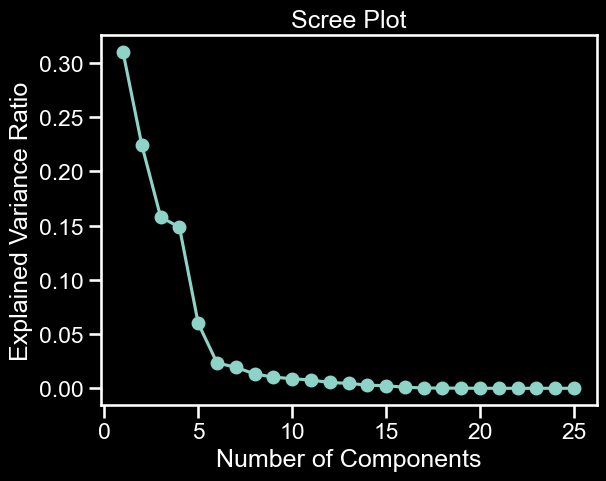

In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/tau/results_tau.csv', sep=';')
column_titles = df.columns.tolist()
output_list = column_titles[3:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(['animal', 'age'],axis=1))

pca = PCA(n_components=None)
pca_data = pca.fit_transform(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

After plotting the explained variance ratio (also known as the scree plot), there are a few other visualizations you can consider to better understand your PCA results:

1. Cumulative Explained Variance Plot: This plot shows the cumulative explained variance as the number of components increases. It can help you decide how many principal components to retain for your analysis.

In [ ]:
import numpy as np
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.show()

2. Scatter Plots: You can create scatter plots of the first few principal components to visualize how data points are distributed based on these components. This can help you identify any patterns or clusters in your data.

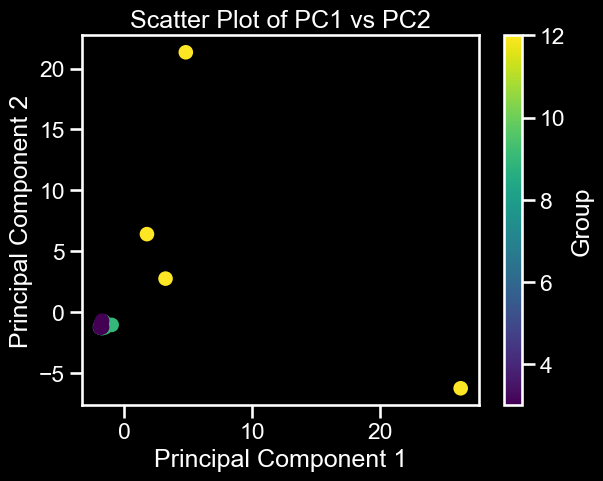

In [46]:
pc1 = pca_data[:, 0]
pc2 = pca_data[:, 1]

plt.scatter(pc1, pc2, c=df['age'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PC1 vs PC2')
plt.colorbar(label='Group')
plt.show()

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
import pandas as pd 
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/tau/results_tau.csv', sep=';')
df = df.loc[:, (df != 0).any()]
column_titles = df.columns.tolist()
output_list = column_titles[3:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(['animal', 'age'],axis=1))

pca = PCA(n_components=3)
pca_data = pca.fit_transform(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_.sum() *100
figsize=(20, 20)
pc1 = pca_data[:, 0]
pc2 = pca_data[:, 1]
pc3 = pca_data[:, 2]
fig = px.scatter_3d(
    x=pc1, y=pc2, z=pc3, color=df['age'], template="plotly_dark")
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'))
fig.update_layout(
    plot_bgcolor="#29212B"  # Set the custom background color
)
fig.update_layout(title='Tau')
fig.update_layout(
    scene_camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=2, y=2, z=2)
    ),
    scene_aspectmode='cube'  # Adjust the aspect ratio to make it closer to a cube
)
fig.show()
# fig.write_image("/Users/annateruel/Desktop/3d_scatter_plot_int.svg", scale=5)

MANOVA on raw data

In [ ]:
from statsmodels.multivariate.manova import MANOVA 
import pandas as pd
df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/results_abeta_intra.csv', sep=';')
#df = df.loc[:, (df != 0).any()]
column_titles = df.columns.tolist()
output_list = column_titles[3:]

formula = " + ".join(output_list)
full_formula = f"{formula} ~ age"
print(full_formula)
fit = MANOVA.from_formula(full_formula, data=df)
print(fit.mv_test().summary_frame)


MANOVA from PC1, PC2, PC3

In [3]:
from statsmodels.multivariate.manova import MANOVA 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/results_abeta_intra.csv', sep=';')
column_titles = df.columns.tolist()
output_list = column_titles[3:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(['animal', 'age'],axis=1))

pca = PCA(n_components=3)
pc_scores = pd.DataFrame(pca.fit_transform(scaled_data), columns = ['PC1', 'PC2', 'PC3'])
pc_scores['age'] = df['age']

fit = MANOVA.from_formula('PC1 + PC2 + PC3~ age', data=pc_scores)
print(fit.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.7291 3.0000 21.0000  2.6015 0.0790
         Pillai's trace 0.2709 3.0000 21.0000  2.6015 0.0790
 Hotelling-Lawley trace 0.3716 3.0000 21.0000  2.6015 0.0790
    Roy's greatest root 0.3716 3.0000 21.0000  2.6015 0.0790
------------------------------------------------------------
                                                            
------------------------------------------------------------
          age           Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6922 3.0000 21.0000  3.1121 0.0481
         Pillai's trace 0.3078 3.0000 21.0000  3.1121 0.0481
 Hotelling-Lawley trace 0.4446 3.0000 21.0

Since the PCA doesn't seem to group correctly by group of age, because there's huge variability, and it doesn't seem that abeta and tau reflect the age, we will run a clustergram to see if there are some brain areas more affected by the presence of beta and tau. 

First, to make data more readable, we're going to delete all columns where all values are 0. Thus, we will not consider brain regions where there is no pathological marker. 

In [ ]:
import pandas as pd

df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/results_abeta_intra.csv', sep=';')
df = df.loc[:, (df != 0).any()]
df = df.iloc[:, 1:]

Thus, we see that from the 900 variables we used to have, we only have quantification in a total of 25 brain regions.

In [ ]:
import numpy as np
corr_matrix = np.corrcoef(df.T).round(decimals=2)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

column_names = df.columns

plt.figure(figsize=(50, 50))  
sns.heatmap(corr_matrix, annot = True, annot_kws={"size": 7})
plt.xticks(np.arange(len(column_names)), column_names, rotation=45, ha='right', fontsize=8)
plt.yticks(np.arange(len(column_names)), column_names, rotation=0, fontsize=8)  # Rotate y-axis labels
plt.show()

In [ ]:
import seaborn as sns

column_names = df.columns

# Compute significance values for correlation matrix
sig_corr_matrix = corr_matrix < 0.05  # Replace 0.05 with your desired significance threshold

plt.figure(figsize=(50, 50))  
sns.heatmap(corr_matrix, annot=sig_corr_matrix, fmt=".2f", cmap='coolwarm',
            annot_kws={"size": 7})
plt.xticks(np.arange(len(column_names)), column_names, rotation=45, ha='right', fontsize=8)
plt.yticks(np.arange(len(column_names)), column_names, rotation=0, fontsize=8)  # Rotate y-axis labels
plt.show()

## MANOVA and PCA on amygdalo-entorhino-hippocampal pathway

Performing MANOVA. In our dataset we have several ages and theis associated object count per brain region in the amygdalo-entorhino-hippocampal pathway

In [ ]:
from statsmodels.multivariate.manova import MANOVA 
import pandas as pd
df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_extra/results_abeta_extra_2.csv', sep=';')
#df = df.loc[:, (df != 0).any()]
column_titles = df.columns.tolist()
output_list = column_titles[3:]

formula = " + ".join(output_list)
full_formula = f"{formula} ~ age"
print(full_formula)
fit = MANOVA.from_formula(full_formula, data=df)
print(fit.mv_test().summary_frame)


Checking for multicolineality in my dataframe we see there's strong collineality between several variables because they have values higher than 5. 

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/tau/results_tau_2.csv', sep=';')
df2 = df.drop(['animal', 'age'],axis=1)

vif_data = pd.DataFrame()
vif_data["Variable"] = df2.columns

# Calculate VIF for each variable
vif_data["VIF"] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
vif_data

/Users/annateruel/miniconda3/envs/dlc_analysis/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Variable,VIF
0,Accessory_olfactory_bulb,NaN
1,Cortical_amygdalar_area,39.949722
2,Dentate_gyrus,43.807858
3,Entorhinal_area,14.982048
4,Field_CA1,11.632955
5,Field_CA2,252.725634
6,Field_CA3,267.460615


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_extra/results_abeta_extra_2.csv', sep=';')
column_titles = df.columns.tolist()
output_list = column_titles[3:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(['animal', 'age'],axis=1))

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_.sum() *100
explained_variance_ratio


91.03608425629439

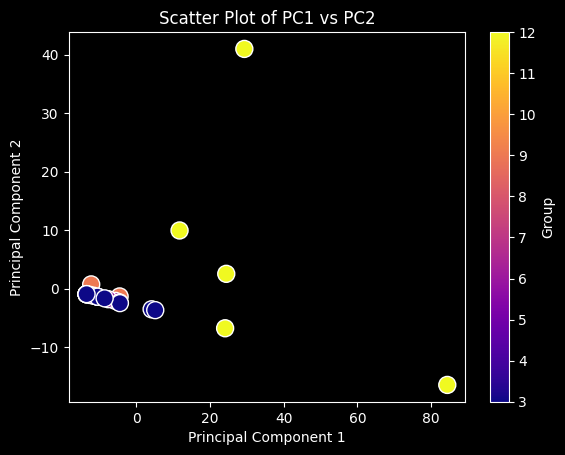

In [27]:
# Scatter plots
from sklearn.decomposition import PCA

df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/tau/results_tau_2.csv', sep=';')
df2 = df.drop(['animal', 'age'],axis=1)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df2)

pc1 = pca_data[:, 0]
pc2 = pca_data[:, 1]

plt.style.use('dark_background')  
plt.scatter(pc1, pc2, c=df['age'], cmap='plasma', s=150, edgecolor='white', linewidth=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PC1 vs PC2')
plt.colorbar(label='Group')
plt.savefig('/Users/annateruel/Desktop/tau.svg', format='svg')

In [ ]:
# Biplot 

import seaborn as sns 

PC1 = pca.fit_transform(df2)[:,0]
PC2 = pca.fit_transform(df2)[:,1]
ldngs = pca.components_

scalePC1 = 1.0/(PC1.max() - PC1.min())
scalePC2 = 1.0/(PC2.max() - PC2.min())
features = df2.feature_names

plt.figure(figsize=(14,9))
 
for i, feature in enumerate(features):
    plt.arrow(0, 0, ldngs[0, i], 
             ldngs[1, i], 
              head_width=0.03, 
             head_length=0.03)
    plt.text(ldngs[0, i] * 1.15, 
            ldngs[1, i] * 1.15, 
            feature, fontsize=18)
 
sns.scatterplot(x=PC1 * scalePC1,
                y=PC2 * scalePC2, 
                hue=target_groups,
                palette="viridis")
 
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.title('Figure 6', fontsize=20)

In [ ]:
pca = PCA(n_components=2)
pc_scores = pd.DataFrame(pca.fit_transform(df2), columns = ['PC1', 'PC2'])
pc_scores['age'] = df['age']

fit = MANOVA.from_formula('PC1 + PC2~ age', data=pc_scores)
print(fit.mv_test())


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

X = pc_scores[["PC1", "PC2"]]
y = pc_scores["age"]
post_hoc = lda().fit(X=X, y=y)


Computing correlation matrix on small dataset of the amygdalo-entorhino-hippocampal pathway. 

In [ ]:
import numpy as np
import seaborn as sns

df = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/results_abeta_intra_2.csv', sep=';')
df = df.iloc[:, 1:]
df = df.loc[:, (df != 0).any()]
column_names = df.columns
corr_matrix = np.corrcoef(df.T).round(decimals=2)

plt.figure(figsize=(10, 10))  
sns.heatmap(corr_matrix, annot = True, annot_kws={"size": 7})
plt.xticks(np.arange(len(column_names)), column_names, rotation=45, ha='right', fontsize=8)
plt.yticks(np.arange(len(column_names)), column_names, rotation=0, fontsize=8)  # Rotate y-axis labels
plt.show()


In [ ]:
from statsmodels.multivariate.manova import MANOVA 

pca = PCA(n_components=3)
pc_scores = pd.DataFrame(pca.fit_transform(scaled_data), columns = ['PC1', 'PC2', 'PC3'])
pc_scores['age'] = df['age']

fit = MANOVA.from_formula('PC1 + PC2 + PC3~ age', data=pc_scores)
print(fit.mv_test())

## ANOVA on the amygdalo-entorhino-hippocampal pathway
Evaluate results for structures in the amygdalo-entorhinal-hippocampal circuit independently

In [5]:
ab_intra = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_intra/results_abeta_intra_2.csv', sep=';')
ab_extra = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/abeta_extra/results_abeta_extra_2.csv', sep=';')
tau = pd.read_csv('/Volumes/ANNA_HD/ANALYSIS/QUINT/output/tau/results_tau_2.csv', sep=';')


In [36]:
# Melt the DataFrame to long format
df2 = pd.melt(tau, id_vars=['animal', 'age'], var_name='brain_area', value_name='cells')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import sem

# Create the plot using seaborn with "plasma" colormap
plt.style.use('dark_background')
plt.figure(figsize=(20, 20))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
# g = sns.catplot(
#     data=df2,
#     x='brain_area',
#     y='cells',
#     hue='age',
#     palette='plasma',
#     s=100,
#     alpha=0.7,
#     kind='swarm',  # Use 'swarm' for separate points
#     aspect=2  # Adjust this aspect value for width
# )
# g.set_xticklabels(rotation=45, horizontalalignment='right')
sns.barplot(
    data=df2,
    x='brain_area',
    y='cells',
    hue='age',
    palette='plasma',
    errcolor='white',  # Set the color of error bars to white
    errwidth=1.0,     # Set the linewidth of error bars to 1.0 (thinner)
    errorbar= 'se'
)

# Customize the plot
plt.xlabel('Brain Area')
plt.ylabel('Cells')
plt.title('Scatterplot and Barplot by Age and Brain Area')
plt.legend(title='Age')

plt.savefig('/Users/annateruel/Desktop/plot_filename.svg', format='svg', bbox_inches='tight')
plt.savefig('/Users/annateruel/Desktop/plot_filename.svg', format='svg', bbox_inches='tight')


In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(25, 10))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
g = sns.catplot(
    data=df2,
    x='brain_area',
    y='cells',
    hue='age',
    palette='plasma',
    kind='violin',
    linewidth=0.5,
    aspect=2  # Adjust this aspect value for width
)
g.set_xticklabels(rotation=45, horizontalalignment='right')



In [37]:
# Perform linear regression
formula = 'cells ~ age * brain_area'
model = smf.ols(formula=formula, data=df2).fit()

# Print ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                      sum_sq     df          F        PR(>F)
brain_area       3273.748571    6.0   7.554390  3.765283e-07
age               872.225188    1.0  12.076302  6.563528e-04
age:brain_area   1370.159389    6.0   3.161733  5.860372e-03
Residual        11628.415423  161.0        NaN           NaN


In [38]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df2['age'] = df2['age'].astype(str)

# Combine 'brain_area' and 'age' into a single interaction factor
df2['interaction'] = df2['brain_area'] + '_' + df2['age']

# Perform Tukey's HSD for pairwise comparisons of the interaction
tukey_results = pairwise_tukeyhsd(df2['cells'], df2['brain_area'])
tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])

sorted_results = tukey_df.sort_values(by=['p-adj'], ascending=True)
sorted_results

,group1,group2,meandiff,p-adj,lower,upper,reject
3,Accessory_olfactory_bulb,Field_CA1,13.12,0.0000,5.4499,20.7901,True
8,Cortical_amygdalar_area,Field_CA1,12.80,0.0000,5.1299,20.4701,True
18,Field_CA1,Field_CA2,-12.00,0.0001,-19.6701,-4.3299,True
15,Entorhinal_area,Field_CA1,12.32,0.0001,4.6499,19.9901,True
12,Dentate_gyrus,Field_CA1,12.24,0.0001,4.5699,19.9101,True
19,Field_CA1,Field_CA3,-10.44,0.0014,-18.1101,-2.7699,True
5,Accessory_olfactory_bulb,Field_CA3,2.68,0.9432,-4.9901,10.3501,False
10,Cortical_amygdalar_area,Field_CA3,2.36,0.9692,-5.3101,10.0301,False
17,Entorhinal_area,Field_CA3,1.88,0.9904,-5.7901,9.5501,False
14,Dentate_gyrus,Field_CA3,1.80,0.9924,-5.8701,9.4701,False


In [ ]:
tukey_results = pairwise_tukeyhsd(df2['cells'], df2['interaction'], alpha=0.05)
p_values_df = pd.DataFrame({'Comparison': tukey_results.groupsunique,
                            'P-Value': tukey_results.pvalues})

# Sort the DataFrame by p-values
p_values_df = p_values_df.sort_values(by='P-Value')
# Create a pivot table for the p-values DataFrame for the heatmap
p_values_pivot = p_values_df.pivot(index='Comparison', columns='Comparison', values='P-Value')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_pivot, annot=True, fmt='.4f', cmap='coolwarm', cbar=True)

# Customize the plot
plt.title('P-Values from Multiple Comparisons')
plt.xlabel('Comparison')
plt.ylabel('Comparison')

# Show the plot
plt.show()
